In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym

# from bettermdptools.algorithms.planner import Planner
from planner import Planner
from plots import Plots

from bettermdptools.utils.test_env import TestEnv
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

from bettermdptools.utils.grid_search import GridSearch
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper
from bettermdptools.algorithms.rl import RL
import itertools

from utils import update_reward

# Explore the setup

In [3]:
MAP_SIZE = 16 #
P_FROZEN = 0.8 # Probability of tile being frozne. if this 0 then there is no path!
N_ITERS = 100000 # all iterations may not be used
THETA = 1e-10 # Convergence threshold
GAMMA = 0.9 # Discount factor
RANDOM_SEED = 42

In [4]:
# in generate_random_map, `S` denotes the start state, `F` denotes the frozen state, `H` denotes the hole state, and `G` denotes the goal state
# `p` is the probability of a tile being frozen
# A path is always guaranteed.
generate_random_map(size=MAP_SIZE, p=P_FROZEN)

['SFFFFHFFFFFHFFFF',
 'FHFFFFFHFHFFFHFF',
 'FFFFFFFFFFFFFFFF',
 'FHFHFFFFFFFFFFFF',
 'HFHHFHFFFFFFFFHF',
 'FFHHFHFFFFFFFHFF',
 'HHFHFFHHFFFFFFFF',
 'FFFHHFFFFFFHFHFF',
 'FFHFFFFHFHFFFFFF',
 'HFFFFFFFFFFFFFFF',
 'HFHFFFFFFHFFFFFH',
 'FHFFFFFFFFHFFFFF',
 'FFFFFFFFHFFFFFFF',
 'HFFFFFFHFFFHHHHF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFHFFFFHFFFFG']

In [5]:
# `desc` parameter is a list of strings, where each string corresponds to a row in the grid
# `is_slippery` parameter determines whether the environment is slippery or not
# P(move left)=1/3
# P(move up)=1/3
# P(move down)=1/3

frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=MAP_SIZE, p=P_FROZEN), is_slippery=False, render_mode="rgb_array")

# desc = ['SFFF', 'FFFF', 'FFHF', 'FFHG']
# frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode="rgb_array")

In [6]:
# There are 4 actions we can take: up, down, left, right
frozen_lake.action_space

Discrete(4)

In [7]:
# The total number of states we can be in - MAP_SIZE * MAP_SIZE
frozen_lake.observation_space

Discrete(256)

In [8]:
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)
print("State: {s_0}, Info: {info}")

State: {s_0}, Info: {info}


In [9]:
frozen_lake.unwrapped.

SyntaxError: invalid syntax (2248397468.py, line 1)

In [10]:
print(frozen_lake.unwrapped.desc.shape)
frozen_lake.unwrapped.desc

(16, 16)


array([[b'S', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'H', b'F',
        b'F', b'H', b'H', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'H', b'F', b'F',
        b'F', b'F', b'F', b'F', b'H'],
       [b'F', b'F', b'H', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F',
        b'F', b'F', b'F', b'H', b'F'],
       [b'F', b'H', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F',
        b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'H', b'F', b'H', b'H', b'H', b'F', b'F', b'F', b'H', b'F',
        b'F', b'F', b'F', b'F', b'H'],
       [b'H', b'H', b'H', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F',
        b'F', b'H', b'F', b'H', b'F'],
       [b'H', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'H',
        b'F', b'F', b'F', b'F', b'H'],
       [b'F', b'H', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F',
        b'H', b'F', b'F', b'F', b'H'],
       [b'F', b'F', b'F', b'F', b'F', b'H', b'H', b'F', b'F', b'F', b'F',
        b'F', b'F', b'

In [11]:
# What is frozen_lake.P? - The reward matrix
# The keys are the states, the values are the actions we can take from that state
# The values are a list of tuples, where each tuple is (probability, next_state, reward, done)
frozen_lake.P  

{0: {0: [(1.0, 0, 0.0, False)],
  1: [(1.0, 16, 0.0, False)],
  2: [(1.0, 1, 0.0, False)],
  3: [(1.0, 0, 0.0, False)]},
 1: {0: [(1.0, 0, 0.0, False)],
  1: [(1.0, 17, 0.0, False)],
  2: [(1.0, 2, 0.0, False)],
  3: [(1.0, 1, 0.0, False)]},
 2: {0: [(1.0, 1, 0.0, False)],
  1: [(1.0, 18, 0.0, False)],
  2: [(1.0, 3, 0.0, False)],
  3: [(1.0, 2, 0.0, False)]},
 3: {0: [(1.0, 2, 0.0, False)],
  1: [(1.0, 19, 0.0, False)],
  2: [(1.0, 4, 0.0, False)],
  3: [(1.0, 3, 0.0, False)]},
 4: {0: [(1.0, 3, 0.0, False)],
  1: [(1.0, 20, 0.0, False)],
  2: [(1.0, 5, 0.0, False)],
  3: [(1.0, 4, 0.0, False)]},
 5: {0: [(1.0, 4, 0.0, False)],
  1: [(1.0, 21, 0.0, False)],
  2: [(1.0, 6, 0.0, False)],
  3: [(1.0, 5, 0.0, False)]},
 6: {0: [(1.0, 5, 0.0, False)],
  1: [(1.0, 22, 0.0, False)],
  2: [(1.0, 7, 0.0, False)],
  3: [(1.0, 6, 0.0, False)]},
 7: {0: [(1.0, 6, 0.0, False)],
  1: [(1.0, 23, 0.0, False)],
  2: [(1.0, 8, 0.0, False)],
  3: [(1.0, 7, 0.0, False)]},
 8: {0: [(1.0, 7, 0.0, False)],


In [12]:
# All the states
frozen_lake.P.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [13]:
# What is stored here?
# 0: left, 1: down, 2: right, 3: up
# From state 254 going right will take us to state 255 (Goal) with a reward of  1.  all other cells are 0
frozen_lake.P[254]

{0: [(1.0, 253, 0.0, False)],
 1: [(1.0, 254, 0.0, False)],
 2: [(1.0, 255, 1.0, True)],
 3: [(1.0, 238, 0.0, False)]}

In [14]:
# What is stored here?
V, V_track, pi, n_i = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

runtime = 0.02 seconds


In [17]:
# P does not get updated. It is the same as before
frozen_lake.P[254]

{0: [(1.0, 253, 0.0, False)],
 1: [(1.0, 254, 0.0, False)],
 2: [(1.0, 255, 1.0, True)],
 3: [(1.0, 238, 0.0, False)]}

In [18]:
# show the map of the environment
frozen_lake.unwrapped.desc

array([[b'S', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'H', b'F',
        b'F', b'H', b'H', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'H', b'F', b'F',
        b'F', b'F', b'F', b'F', b'H'],
       [b'F', b'F', b'H', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F',
        b'F', b'F', b'F', b'H', b'F'],
       [b'F', b'H', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F',
        b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'H', b'F', b'H', b'H', b'H', b'F', b'F', b'F', b'H', b'F',
        b'F', b'F', b'F', b'F', b'H'],
       [b'H', b'H', b'H', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F',
        b'F', b'H', b'F', b'H', b'F'],
       [b'H', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'H',
        b'F', b'F', b'F', b'F', b'H'],
       [b'F', b'H', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F',
        b'H', b'F', b'F', b'F', b'H'],
       [b'F', b'F', b'F', b'F', b'F', b'H', b'H', b'F', b'F', b'F', b'F',
        b'F', b'F', b'

In [14]:
# We take a step and see the outcome
# TODO: This is what is needed to be done in the RL algorithm - define the correct step function. based on Policy iteration or Value iteration
a_t = frozen_lake.action_space.sample()
s_t_next, r_t, d_t, truncated,info = frozen_lake.step(a_t)

# Tuncated means that the episode has ended
# terminated means that the robot has reached goal or fallen into a hole


print(f"Action taken: {a_t}, Next state: {s_t_next}, Reward: {r_t}, Terminated: {d_t}, Truncated: {truncated}, Info: {info}")

Action taken: 3, Next state: 0, Reward: 0.0, Terminated: False, Truncated: False, Info: {'prob': 1.0}


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [21]:
t_ev = TestEnv.test_env(frozen_lake, n_iters=1000, pi=pi)


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [22]:
t_ev

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

# Basic VI /PI - with and without the slip

In [ ]:
MAP_SIZE = 16 
P_FROZEN = 0.8 # Probability of tile being frozen
N_ITERS = 300
THETA = 1e-10 # Convergence threshold
GAMMA = 0.9 # Discount factor
RANDOM_SEED = 42
IS_SLIPPERY = False

In [ ]:
# Test graph
desc = ['SFFFHHHFFFFFFFFF',
 'FHHFFFFFFFHFHFFF',
 'FFHFHFFFFFFFFFFF',
 'FFFHFFFFFFFFFFHH',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFHFFFFFFFH',
 'FFFFHFFFFFFFFFFF',
 'FHFFFFFFHFFHFFFF',
 'HHFFHFFFHFFFHFFH',
 'HFHHFFFFFFFHFHFF',
 'FFHFFHFHHFHFFFFF',
 'FFFFFFFFFFFHFFFH',
 'FHFHFFFFFHFFFFFF',
 'FHHFFHFFFFFFFHFF',
 'FFFFFHFFHFFHHFFG']

In [ ]:
frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=IS_SLIPPERY, render_mode="rgb_array")

# frozen_lake = update_rewards(frozen_lake)

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
V, V_track, pi, n_i = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

# V is the final value
# V_track is the value of each state at each iteration
# pi is the final policy - mapping states to actions

print(f"n_i : {n_i}")

runtime = 0.02 seconds
n_i : 31


In [ ]:
TestEnv().test_env(frozen_lake, n_iters=10, pi=pi)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
# frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=True, render_mode="human")
frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=True, render_mode="rgb_array")

# frozen_lake = update_rewards(frozen_lake)

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
V, V_track, pi, n_i = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

# V is the final value
# V_track is the value of each state at each iteration
# pi is the final policy - mapping states to actions

print(f"n_i : {n_i}")

runtime = 0.22 seconds
n_i : 154


In [ ]:
TestEnv().test_env(frozen_lake, n_iters=1000, pi=pi)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=IS_SLIPPERY, render_mode="rgb_array")

frozen_lake = update_rewards(frozen_lake)

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
V, V_track, pi, n_i = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

# V is the final value
# V_track is the value of each state at each iteration
# pi is the final policy - mapping states to actions

print(f"n_i : {n_i}")

runtime = 0.02 seconds
n_i : 31


In [ ]:
TestEnv().test_env(frozen_lake, n_iters=1000, pi=pi)

c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


array([99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71, 99.71,
       99.71, 99.71,

In [ ]:
# frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=True, render_mode="human")
frozen_lake = gym.make('FrozenLake-v1', desc=desc, is_slippery=True, render_mode="rgb_array")

frozen_lake = update_rewards(frozen_lake)

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
V, V_track, pi, n_i = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

# V is the final value
# V_track is the value of each state at each iteration
# pi is the final policy - mapping states to actions

print(f"n_i : {n_i}")

runtime = 0.26 seconds
n_i : 172


In [ ]:
TestEnv().test_env(frozen_lake, n_iters=1000, pi=pi)

array([-0.02,  0.  , -0.01, -0.01, -0.02, -0.08,  0.  , -0.01,  0.  ,
       -0.07,  0.  , -0.03, -0.01,  0.  ,  0.  , -0.06,  0.  , -0.06,
       -0.02,  0.  , -0.01, -0.02, -0.01, -0.03, -0.02, -0.03, -0.05,
       -0.05,  0.  , -0.03, -0.02, -0.02, -0.03,  0.  ,  0.  , -0.15,
       -0.04, -0.01, -0.04,  0.  , -0.02,  0.  , -0.01,  0.  ,  0.  ,
       -0.02, -0.03, -0.01,  0.  , -0.03, -0.01, -0.02,  0.  , -0.03,
       -0.01, -0.04, -0.03, -0.08, -0.08,  0.  , -0.01, -0.01, -0.04,
        0.  , -0.01, -0.01, -0.01,  0.  ,  0.  ,  0.  ,  0.  , -0.07,
       -0.03, -0.02, -0.02, -0.01, -0.04, -0.02, -0.01,  0.  ,  0.  ,
        0.  , -0.01, -0.06, -0.01, -0.03, -0.01, -0.01, -0.04, -0.01,
       -0.02, -0.04,  0.  , -0.04,  0.  , -0.02, -0.03,  0.  , -0.01,
        0.  , -0.05, -0.05, -0.02, -0.01, -0.03, -0.03, -0.03, -0.03,
        0.  , -0.03, -0.01, -0.05, -0.04, -0.03, -0.01, -0.01, -0.01,
        0.  ,  0.  ,  0.  , -0.04,  0.  , -0.04, -0.01,  0.  ,  0.  ,
       -0.06, -0.02,

In [ ]:
MAP_SIZE = 16 
P_FROZEN = 0.8 # Probability of tile being frozen
N_ITERS = 300
THETA = 1e-10 # Convergence threshold
GAMMA = 0.9 # Discount factor
RANDOM_SEED = 42
IS_SLIPPERY = False

In [ ]:
desc_no_holes = ['SFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFG']

In [ ]:

# frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=MAP_SIZE, p=P_FROZEN), is_slippery=IS_SLIPPERY, render_mode="rgb_array")
frozen_lake = gym.make('FrozenLake-v1', desc=desc_no_holes, is_slippery=IS_SLIPPERY, render_mode="human")

# frozen_lake = update_rewards(frozen_lake)

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
V, V_track, pi, n_i = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

# V is the final value
# V_track is the value of each state at each iteration
# pi is the final policy - mapping states to actions

print(f"n_i : {n_i}")


runtime = 0.02 seconds
n_i : 31


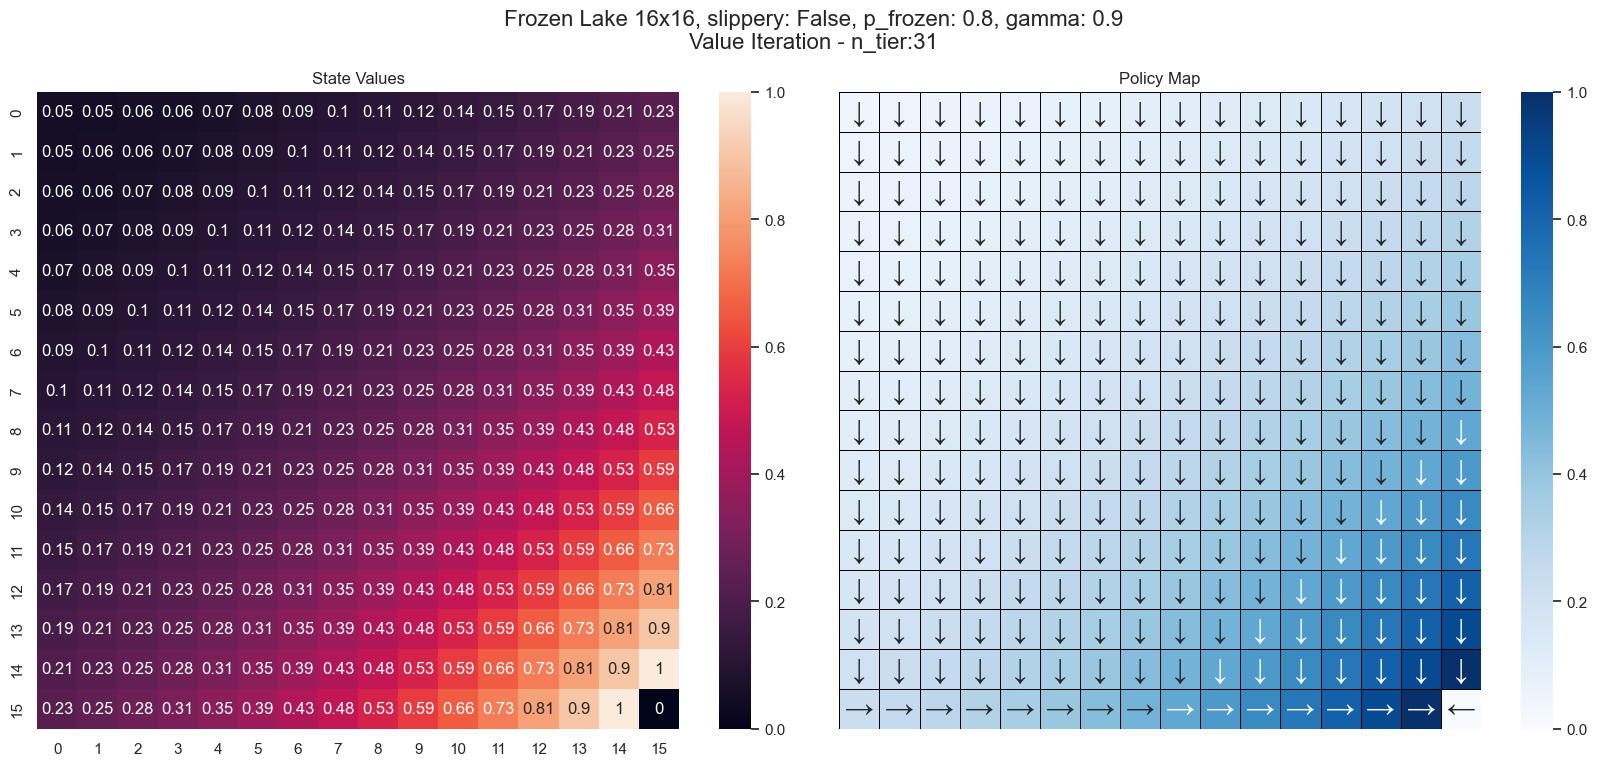

In [ ]:
# plot state values
sns.set_theme(rc={'figure.figsize':(20.7,8.27)})

fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0, hspace=0)

size=(MAP_SIZE, MAP_SIZE)

Plots.values_heat_map(V, "State Values", size, ax[0])

v_max, directions = Plots.get_policy_map(pi, V, {0: "←", 1: "↓", 2: "→", 3: "↑"}, size)

Plots.plot_policy(v_max, directions=directions, title='Policy Map', ax=ax[1])

fig.suptitle(f'Frozen Lake {MAP_SIZE}x{MAP_SIZE}, slippery: {IS_SLIPPERY}, p_frozen: {P_FROZEN}, gamma: {GAMMA}\nValue Iteration - n_tier:{n_i}', fontsize=16);


In [ ]:
# frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=MAP_SIZE, p=P_FROZEN), is_slippery=IS_SLIPPERY, render_mode="rgb_array")
frozen_lake = gym.make('FrozenLake-v1', desc=desc_no_holes, is_slippery=True, render_mode="human")

# frozen_lake = update_rewards(frozen_lake)

# reset the map first
s_0, info = frozen_lake.reset(seed=RANDOM_SEED)

# run VI
V, V_track, pi, n_i = Planner(frozen_lake.P).value_iteration(gamma=GAMMA, n_iters=N_ITERS, theta=THETA)

# V is the final value
# V_track is the value of each state at each iteration
# pi is the final policy - mapping states to actions

print(f"n_i : {n_i}")

runtime = 0.23 seconds
n_i : 153


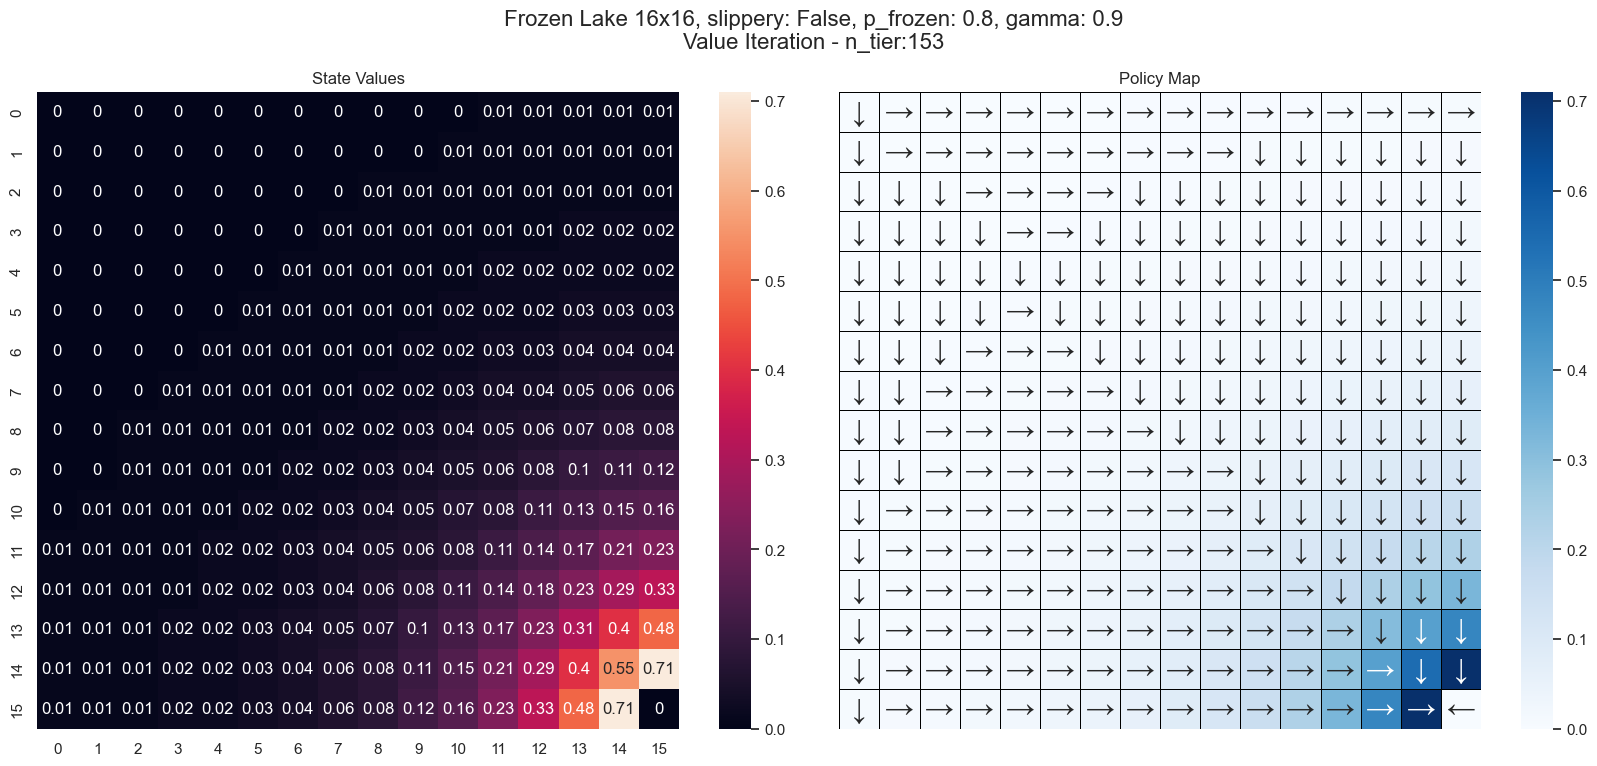

: 

In [ ]:
# plot state values
sns.set_theme(rc={'figure.figsize':(20.7,8.27)})

fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0, hspace=0)

size=(MAP_SIZE, MAP_SIZE)

Plots.values_heat_map(V, "State Values", size, ax[0])

v_max, directions = Plots.get_policy_map(pi, V, {0: "←", 1: "↓", 2: "→", 3: "↑"}, size)

Plots.plot_policy(v_max, directions=directions, title='Policy Map', ax=ax[1])

fig.suptitle(f'Frozen Lake {MAP_SIZE}x{MAP_SIZE}, slippery: {IS_SLIPPERY}, p_frozen: {P_FROZEN}, gamma: {GAMMA}\nValue Iteration - n_tier:{n_i}', fontsize=16);
